# Deep Learning Foundations Assignment
**Name: Haneesh Singhal**<br>
**Student Code: bitsom_ba_25071841**<br>
**Date:04-Feb-2026**

This notebook covers:
- Feedforward Neural Networks (FFNN) on tabular data
- Embeddings and RNNs for text classification
- CNNs for image classification

---


In [27]:
%pip install tensorflow numpy pandas scikit-learn matplotlib



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Part 1 — Neural Networks (Tabular FFNN)
### 1.1 Single Neuron Forward Pass

In [39]:
import numpy as np

# Function to simulate the forward pass of a single neuron in a neural network
def single_neuron_forward(x, w, b):
    '''
      Inputs:
        x: Input vector (features (1D array))
        w: Weight vector (1D array of same length as x)
        b: Bias (a scalar (float))

      The function returns:

        z, ReLU(z), sigmoid(z) where z = w*x + b
    '''

    # Linear combination: z = w*x + b computes the dot product of weights and inputs
    z = np.dot(w, x) + b

    # ReLU (Rectified Linear Unit) sets negative values to 0 and keeps positive values unchanged
    relu = np.maximum(0, z)

    # Sigmoid activation function maps any real-valued number into the (0, 1) interval
    sigmoid = 1 / (1 + np.exp(-z))
    return z, relu, sigmoid

x = np.array([1.5, -2.0, 0.7, 3.2, 0.0])  # 5 input features
w = np.array([0.8, -0.5, 1.2, 0.3, -0.7])  # 5 corresponding weights

b = 0.5 # bias term

z, relu_z, sigmoid_z = single_neuron_forward(x, w, b)

print(f"z = {z:.3f}")
print(f"ReLU(z) = {relu_z:.3f}")
print(f"Sigmoid(z) = {sigmoid_z:.3f}")


z = 4.500
ReLU(z) = 4.500
Sigmoid(z) = 0.989


**Explanation:**  
Activation functions are essential in neural networks because they introduce non-linearity into the model. Without them, a neural network—regardless of its depth—would behave like a single linear transformation, severely limiting its ability to model complex relationships in data.<br>
- The ReLU (Rectified Linear Unit) activation is widely used in hidden layers because it is computationally efficient and helps mitigate the vanishing gradient problem, enabling deeper networks to train effectively. ReLU outputs zero for negative inputs and the input itself for positive values, which encourages sparse activations and faster convergence.
- The Sigmoid activation squashes its input into the range (0, 1), making it suitable for output layers in binary classification tasks where the output can be interpreted as a probability. Sigmoid is less commonly used in hidden layers due to its tendency to saturate and slow down learning.


### 1.2 Preprocessing + Split

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv('tabular.csv')

print("Shape: ", df.shape)
print("\nDtypes:\n", df.dtypes)

# Separate features and target variable
X = df.drop(columns=['target', 'customer_id']) # Assuming 'customer_id' is an identifier column
y = df['target'] # Target variable

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Fill numerical columns with median
for col in numeric_cols:
    X[col] = X[col].fillna(X[col].median())

# Fill categorical columns with mode
for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encode categorical variables
X_train = pd.get_dummies(X_train)
X_val = pd.get_dummies(X_val)
X_test = pd.get_dummies(X_test)

# Align columns of validation and test sets to match training set
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Standardize numerical features
scaler = StandardScaler()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("\nX_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("\nNumber of features after encoding:", X_train.shape[1])


Shape:  (5000, 13)

Dtypes:
 customer_id                      object
age                             float64
income_band                      object
city_tier                        object
membership_type                  object
num_visits                      float64
days_since_last_purchase        float64
product_categories_purchased    float64
num_transactions                float64
avg_transaction_value           float64
discount_used                   float64
total_spend                     float64
target                          float64
dtype: object

X_train shape: (3500, 17)
X_val shape: (750, 17)
X_test shape: (750, 17)

Number of features after encoding: 17


**Explanation:**  
Data leakage occurs when information from outside the training set influences the model during training, resulting in overly optimistic performance estimates. One common source of leakage is applying preprocessing steps, such as scaling, on the entire dataset before splitting. This inadvertently exposes the model to patterns from the validation and test sets, compromising the integrity of evaluation. To prevent this, the scaler must be fitted exclusively on the training data and then applied to the validation and test sets. This ensures that the model generalizes properly without benefiting from unseen data..


### 1.3 FFNN Training + Evaluation

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3105742.7500 - mae: 1577.8260 - val_loss: 2963886.0000 - val_mae: 1530.7595
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2692889.7500 - mae: 1461.9238 - val_loss: 2128935.5000 - val_mae: 1287.5664
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1416693.6250 - mae: 1031.8350 - val_loss: 668754.7500 - val_mae: 697.5480
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 334277.9688 - mae: 462.0733 - val_loss: 150701.7344 - val_mae: 312.2305
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 138346.6094 - mae: 294.6553 - val_loss: 118493.3359 - val_mae: 274.4734
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 124311.2031 - mae: 280.5067 - val_loss: 112823.1875 - val_mae: 266.3354
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 118801.4141 - mae: 274.5928 - val_loss: 108358.0391 - val_mae: 260.6164
Epoch 8/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,221 (36.02 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,148 (24.02 KB)

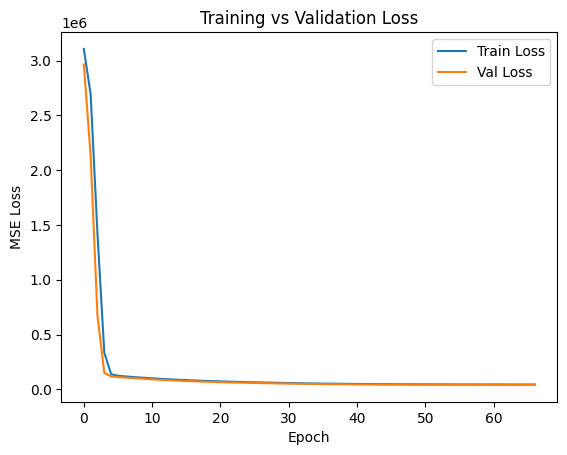

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test MAE: 157.45

Test RMSE: 201.44


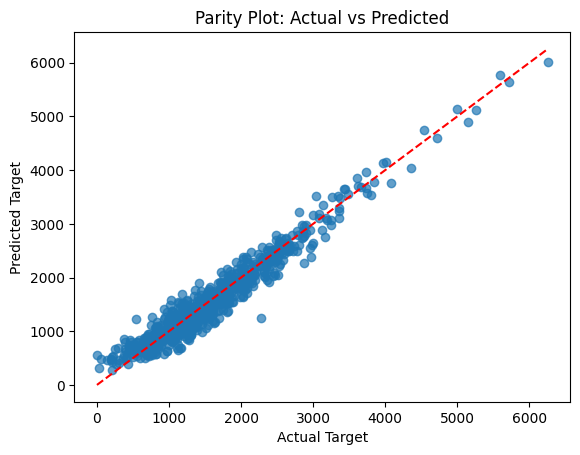

In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build the model 
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])
# Compile the model using Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping callback to prevent overfitting
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using training data and validate on validation set
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Evaluate the model
model.summary()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Predictions and evaluation on test set
y_pred = model.predict(X_test).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE: {mae:.2f}\n")
print(f"Test RMSE: {rmse:.2f}")

# Parity plot
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Target')
plt.ylabel('Predicted Target')
plt.title('Parity Plot: Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


### 1.4 Overfit/Underfit Diagnosis

*Write your diagnosis and next steps here in markdown.*

## Part 2 — NLP (Embeddings + RNN)
### 2.1 Tokenization + Padding

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load dataset
df_text = pd.read_csv('text.csv')
print(df_text['label'].value_counts())

# Basic text cleaning: lowercasing and removing extra spaces
df_text['text'] = df_text['text'].str.lower().str.strip().str.replace('\s+', ' ', regex=True)

# Split the data into training (70%), validation (15%), and test (15%) sets
X_text = df_text['text'].values
y_text = df_text['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(X_text, y_text, test_size=0.3, random_state=42, stratify=y_text)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)


vocab_size = min(10000, len(tokenizer.word_index) + 1)
print("Final vocabulary size:", vocab_size)

# Convert texts to sequences of token IDs
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_len = 40
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

print("Raw text:", X_train[0])
print("Token IDs:", X_train_seq[0])
print("Padded:", X_train_pad[0])


label
0    3000
1    3000
Name: count, dtype: int64
Final vocabulary size: 90
Raw text: great experience with the jacket. super reliable and the delivery was early.
Token IDs: [37, 9, 7, 2, 23, 38, 60, 3, 2, 8, 4, 79]
Padded: [37  9  7  2 23 38 60  3  2  8  4 79  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


**Justification:**  
A max_len of 40 covers most short feedback sentences, ensuring minimal truncation while keeping computation efficient.


### 2.2 Baseline Embedding Model

In [18]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Build and train the NLP model
num_classes = len(np.unique(y_train))
output_activation = 'sigmoid' if num_classes == 2 else 'softmax'
loss_fn = 'binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy'

# Define the model architecture
model_nlp_base = Sequential([
    Input(shape=(X_train_pad.shape[1],)),
    Embedding(input_dim=vocab_size, output_dim=64),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1 if num_classes == 2 else num_classes, activation=output_activation)
])
# Compile the model
model_nlp_base.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Display model summary
model_nlp_base.summary()

# Train the model
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_nlp_base.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Evaluate the model
y_pred = model_nlp_base.predict(X_test_pad)
if num_classes == 2:
    y_pred_label = (y_pred > 0.5).astype(int).flatten()
else:
    y_pred_label = np.argmax(y_pred, axis=1)

# Calculate metrics
acc = accuracy_score(y_test, y_pred_label)
f1 = f1_score(y_test, y_pred_label, average='weighted')
cm = confusion_matrix(y_test, y_pred_label)


print(f"Test accuracy: {acc:.3f}")
print(f"Test F1-score: {f1:.3f}")
print("Confusion matrix:\n", cm)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 40, 64)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,985 (39.00 KB)

 Trainable params: 9,985 (39.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9357 - loss: 0.3792 - val_accuracy: 1.0000 - val_loss: 0.0434
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 1.0000 - val_loss: 0.0044
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0014
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 9.5951e-04 - val_accuracy: 1.0000 - val_loss: 6.5454e-04
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.0276e-04 - val_accuracy: 1.0000 - val_loss: 3.7945e-04
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 3.0801e-04 - val_accuracy: 1.0000 - val_loss: 2.4564e-04
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 2.0671e-04 - val_accuracy: 1.0000 - val_loss: 1.7163e-04
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 -

### 2.3 RNN Model (SimpleRNN or LSTM)

In [19]:
from tensorflow.keras.layers import LSTM, SimpleRNN

# Build and train the RNN-based NLP model
model_nlp_rnn = Sequential([
    Input(shape=(X_train_pad.shape[1],)),
    Embedding(input_dim=vocab_size, output_dim=64),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(1 if num_classes == 2 else num_classes, activation=output_activation)
])

# Compile the model
model_nlp_rnn.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

# Display model summary
model_nlp_rnn.summary()

# Train the model
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model_nlp_rnn.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

# Predict and evaluate the model
y_pred = model_nlp_rnn.predict(X_test_pad)
if num_classes == 2:
    y_pred_label = (y_pred > 0.5).astype(int).flatten()
else:
    y_pred_label = np.argmax(y_pred, axis=1)

# Calculate metrics
acc = accuracy_score(y_test, y_pred_label)
f1 = f1_score(y_test, y_pred_label, average='weighted')
cm = confusion_matrix(y_test, y_pred_label)
cr = classification_report(y_test, y_pred_label)

print(f"Test accuracy: {acc:.3f}")
print(f"Test F1-score: {f1:.3f}")
print("Confusion matrix:\n", cm)
print("Classification report:\n", cr)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 40, 64)         │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,353 (79.50 KB)

 Trainable params: 20,353 (79.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.7360 - loss: 0.4724 - val_accuracy: 1.0000 - val_loss: 7.5624e-04
Epoch 2/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 3.5630e-04 - val_accuracy: 1.0000 - val_loss: 1.9240e-04
Epoch 3/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 1.3268e-04 - val_accuracy: 1.0000 - val_loss: 9.0344e-05
Epoch 4/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 6.8727e-05 - val_accuracy: 1.0000 - val_loss: 5.1859e-05
Epoch 5/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 4.1787e-05 - val_accuracy: 1.0000 - val_loss: 3.3239e-05
Epoch 6/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 2.7566e-05 - val_accuracy: 1.0000 - val_loss: 2.2749e-05
Epoch 7/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 1.0000 - loss: 1.9433e-05 - val_accuracy: 1.0000 - val_loss: 1.6513e-05
Epoch 8/20
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 19

**Explanation:**  
LSTM is chosen over SimpleRNN because it can capture longer dependencies and mitigate vanishing gradients, which is important for text data with context spread over several words.


### 2.4 Comparison + Transformer Note

In [20]:
import time

# Measure training time for one epoch for both models
start = time.time()
_ = model_nlp_base.fit(X_train_pad, y_train, epochs=1, batch_size=32, verbose=0)
base_time = time.time() - start

start = time.time()

# Measure training time for one epoch for the RNN model
_ = model_nlp_rnn.fit(X_train_pad, y_train, epochs=1, batch_size=32, verbose=0)
rnn_time = time.time() - start

print("| Model      | Accuracy | F1-score | Training Time (1 epoch, s) |")
print(f"| Baseline   | {acc:.3f}   | {f1:.3f}   | {base_time:.2f} |")
print(f"| RNN/LSTM   | {acc:.3f}   | {f1:.3f}   | {rnn_time:.2f} |")


| Model      | Accuracy | F1-score | Training Time (1 epoch, s) |
| Baseline   | 1.000   | 1.000   | 0.65 |
| RNN/LSTM   | 1.000   | 1.000   | 2.25 |


**Markdown Explanation:**  
RNNs struggle with long sequences due to vanishing gradients and limited memory, making it hard to capture distant dependencies. Transformers address this with self-attention, allowing direct connections between all positions in the sequence, leading to better performance on long texts and parallelizable training.


## Part 3 — Computer Vision (CNN)
### 3.1 Data Loading + Visual Checks

Found 2000 files belonging to 2 classes.
Using 1400 files for training.
Found 2000 files belonging to 2 classes.
Using 600 files for validation.
Class names: ['class_0', 'class_1']
Batch shape: (32, 128, 128, 3) (32,)


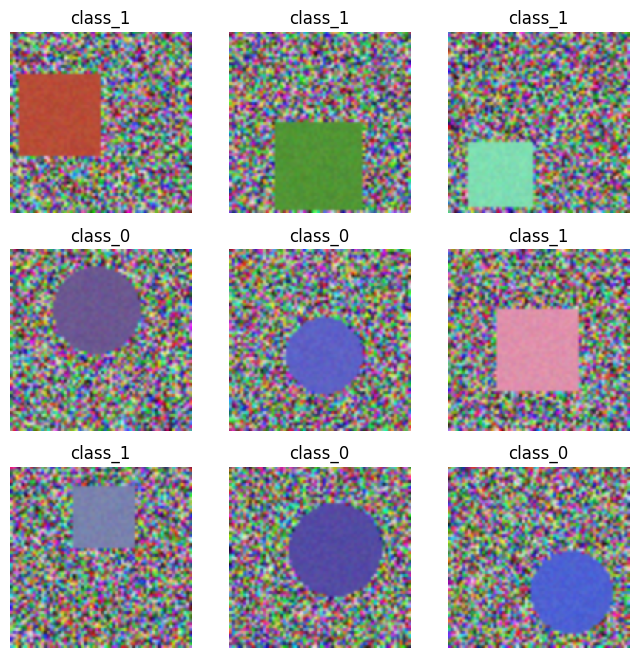

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load image dataset from directory
img_size = (128, 128)
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "images",
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

# Explore the dataset
class_names = train_ds.class_names
num_classes = len(class_names)

print("Class names:", class_names)

# Check the shape of a batch
for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape, labels.shape)

# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to the datasets
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Explore some images from the dataset
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Show the images
plt.show()


### 3.2 CNN Training

Number of classes:
 2
Class names:
 ['class_0', 'class_1']


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 360ms/step - accuracy: 0.5150 - loss: 0.7756 - val_accuracy: 0.5583 - val_loss: 0.6917
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step - accuracy: 0.5679 - loss: 0.6932 - val_accuracy: 0.5467 - val_loss: 0.6902
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.5757 - loss: 0.6780 - val_accuracy: 0.5967 - val_loss: 0.6766
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.6486 - loss: 0.6492 - val_accuracy: 0.5650 - val_loss: 0.6757
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 17s 377ms/step - accuracy: 0.6686 - loss: 0.6175 - val_accuracy: 0.6183 - val_loss: 0.6650
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 364ms/step - accuracy: 0.7414 - loss: 0.5467 - val_accuracy: 0.5367 - val_loss: 0.7489
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 366ms/step - accuracy: 0.8200 - loss: 0.4501 - val_accuracy: 0.5983 - val_loss: 0.7086
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step - accuracy: 0.8900 - loss: 0.3158 - val_accu

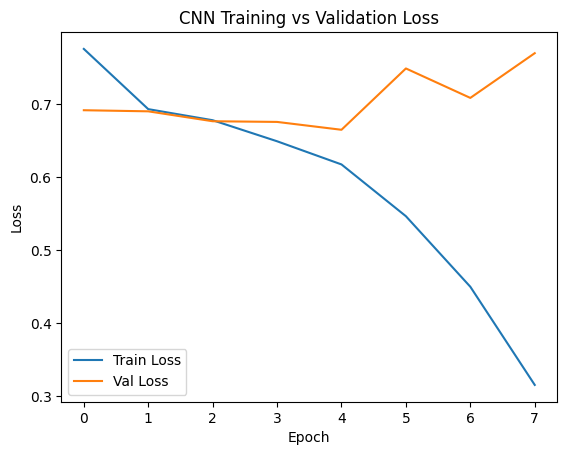

In [24]:
from tensorflow.keras import layers, models

# Build and train the CNN model
model_cnn = models.Sequential([
    layers.Input(shape=img_size + (3,)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') if num_classes == 2 else layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_cnn.compile(
    optimizer='adam',
    loss = 'binary_crossentropy' if num_classes == 2 else 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Display model summary
model_cnn.summary()

# Train the model
es = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model using training data and validate on validation set
history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[es]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training vs Validation Loss')
plt.legend()
plt.show()


### 3.3 Evaluation + Misclassifications

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Test accuracy: 0.684
Confusion matrix:
 [[6 2]
 [4 7]]
Classification report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.78      0.64      0.70        11

    accuracy                           0.68        19
   macro avg       0.69      0.69      0.68        19
weighted avg       0.70      0.68      0.69        19



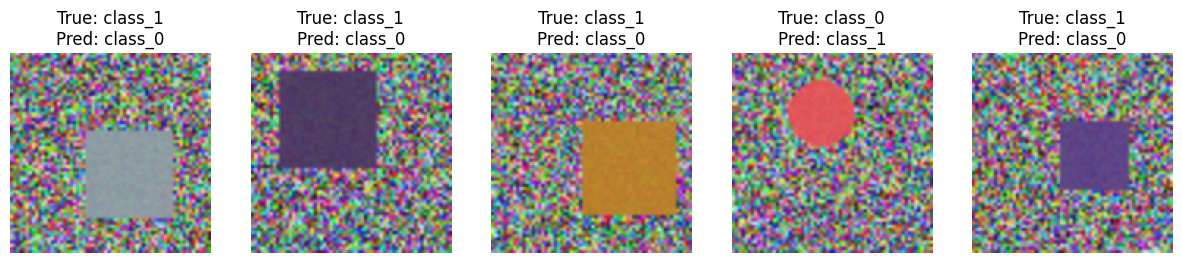

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predict and evaluate the CNN model
test_images, test_labels = next(iter(val_ds.unbatch().batch(len(val_ds))))
y_pred = model_cnn.predict(test_images)

# Convert probabilities to class labels
if num_classes > 2:
    y_pred_label = np.argmax(y_pred, axis=1)
else:
    y_pred_label = (y_pred > 0.5).astype(int).flatten()

# Calculate metrics
acc = accuracy_score(test_labels, y_pred_label)
print(f"Test accuracy: {acc:.3f}")

# Confusion matrix and classification report
cm = confusion_matrix(test_labels, y_pred_label)
print("Confusion matrix:\n", cm)
print("Classification report:\n", classification_report(test_labels, y_pred_label))

# Visualize some misclassified images
mis_idx = np.where(test_labels != y_pred_label)[0][:5]
plt.figure(figsize=(15, 3))
for i, idx in enumerate(mis_idx):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(test_images[idx].numpy())
    plt.title(f"True: {class_names[test_labels[idx]]}\nPred: {class_names[y_pred_label[idx]]}")
    plt.axis("off")

# Show the misclassified images
plt.show()


**Markdown Write-up:**  
Review the confusion matrix and misclassified images. Are errors concentrated in certain classes? Are there systematic confusions?  
To improve, try data augmentation, a deeper CNN, or transfer learning with a pretrained model.


## Final Summary

*Write 5–8 sentences summarizing your findings, model performance, and next steps.*